# Import Libraries

In [1]:
from encoder.encoder import TextEncoder
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import os

# Prepare Function

In [2]:
def cosine_similarity(a, b):
    type_a = type(a)
    type_b = type(b)
    assert type_a == type_b, f"Type mismatch: {type_a} != {type_b}"

    if type_a == torch.Tensor:
        return a.dot(b) / (a.norm() * b.norm())
    
    elif type_a == np.ndarray:
        return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    return None

# Initialize Text Encoder

In [3]:
model_name = "BAAI/bge-m3" # "airesearch/wangchanberta-base-att-spm-uncased", "BAAI/bge-m3"
encoder = TextEncoder(model_name)

# Test Encoder

In [4]:
example_text = "สวัสดีครับ ผมชื่อหมูเด้ง ยินดีที่ได้รู้จักครับ"
example_embedding = encoder.encode(example_text)

print(f"Embedding shape: {example_embedding.shape}")

Embedding shape: torch.Size([1, 1024])


# Load and Preview Data

In [5]:
generated_path = "../generated/reviewed/combined_sentences_reviewed.csv"
df = pd.read_csv(generated_path)
df

,thai sentence,english sentence
0,แม้ว่าฝนจะตกหนัก แต่ฉันก็ยังต้องไปทำงานเพราะมี...,"Even though it's raining heavily, I still have..."
1,เมื่อวานฉันได้พบกับเพื่อนเก่าที่ไม่ได้เจอกันมา...,Yesterday I met an old friend whom I haven't s...
2,ถ้าคุณมีเวลาว่างสุดสัปดาห์นี้ เราไปเที่ยวภูเขา...,"If you have free time this weekend, should we ..."
3,ฉันกำลังเรียนทำอาหารไทย เพราะอยากทำอาหารอร่อยๆ...,I am learning to cook Thai food because I want...
4,ก่อนที่จะตัดสินใจซื้อบ้านหลังนี้ เราควรพิจารณา...,"Before deciding to buy this house, we should c..."
...,...,...
2801,เราควรอนุรักษ์วัฒนธรรมและประเพณีที่ดีงามของเรา,We should preserve our good culture and tradit...
2802,การเดินทางทำให้เราได้เรียนรู้และเห็นโลกในมุมที...,Traveling allows us to learn and see the world...
2803,ฉันสนใจเรื่องการถ่ายภาพและอยากปรับปรุงทักษะของ...,I'm interested in photography and want to impr...
2804,คุณคิดว่าอนาคตของเทคโนโลยีจะเป็นอย่างไร,What do you think the future of technology wil...


# Encode

In [6]:
encoded_texts = []
for index, row in tqdm(df.iterrows(), desc="Encoding", total=len(df)):
    text = row["thai sentence"]
    encoded_text = encoder.encode(text)
    encoded_texts.append(encoded_text)

Encoding: 100%|██████████| 2806/2806 [00:32<00:00, 87.14it/s]


In [7]:
encoded_texts = [enc.flatten().cpu().numpy() for enc in encoded_texts]
np_encoded_texts = np.array(encoded_texts)

# Cosine Similarity

In [8]:
cosine_similarities = {} # keys (i, j) where i < j
for i in tqdm(range(len(np_encoded_texts)), desc="Calculating cosine similarities", total=len(np_encoded_texts)):
    for j in range(i + 1, len(np_encoded_texts)):
        cosine_sim = cosine_similarity(np_encoded_texts[i], np_encoded_texts[j])
        cosine_similarities[(i, j)] = cosine_sim

Calculating cosine similarities: 100%|██████████| 2806/2806 [00:19<00:00, 145.29it/s]


# Save the result for reusable

In [9]:
os.makedirs("pickled", exist_ok=True)

with open("pickled/cosine_similarities.pkl", "wb") as f:
    pickle.dump(cosine_similarities, f)
with open(f"pickled/embeddings_{model_name.split('/')[-1]}.pkl", "wb") as f:
    pickle.dump(np_encoded_texts, f)

# Plot histogram

In [10]:
sorted_cosine_similarities = sorted(cosine_similarities.items(), key=lambda x: x[1], reverse=True)

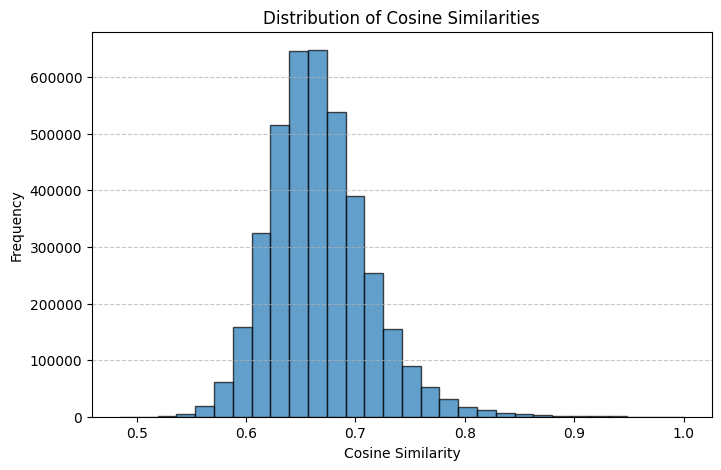

In [11]:
flattened_cosine_similarities = list(cosine_similarities.values())

plt.figure(figsize=(8, 5))
plt.hist(flattened_cosine_similarities, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Cosine Similarities")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("results/cosine_similarity_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Thresholding

In [13]:
threshold = 0.9
cos_sims, line1, sent1, line2, sent2 = [], [], [], [], []
for (i, j), cosine_sim in sorted_cosine_similarities:
    if cosine_sim < threshold:
        break
    cos_sims.append(round(cosine_sim, 3))
    line1.append(i+2)
    line2.append(j+2)
    sent1.append(df.iloc[i]['thai sentence'])
    sent2.append(df.iloc[j]['thai sentence'])
df_sim = pd.DataFrame({"cosine similarity": cos_sims, "line1": line1, "sentence1": sent1, "line2": line2, "sentence2": sent2})
df_sim.to_csv("results/cosine_similarities.csv", index=False)
print(f"Cosine similarity above threshold: {threshold} is saved")

Cosine similarity above threshold: 0.9 is saved
